In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import copy


from PIL import Image

DATASET_SIZE = 2500
BATCH_SIZE = 20
W = H = 256

train_path = 'C:/Users/ehgml/data/train/'
test_path = 'C:/Users/ehgml/data/test/'

LABEL_MAP = {
0: "Nucleoplasm" ,
1: "Nuclear membrane"   ,
2: "Nucleoli"   ,
3: "Nucleoli fibrillar center",   
4: "Nuclear speckles"   ,
5: "Nuclear bodies"   ,
6: "Endoplasmic reticulum"   ,
7: "Golgi apparatus"  ,
8: "Peroxisomes"   ,
9:  "Endosomes"   ,
10: "Lysosomes"   ,
11: "Intermediate filaments"  , 
12: "Actin filaments"   ,
13: "Focal adhesion sites"  ,
14: "Microtubules"   ,
15: "Microtubule ends"   ,
16: "Cytokinetic bridge"   ,
17: "Mitotic spindle"  ,
18: "Microtubule organizing center",  
19: "Centrosome",
20: "Lipid droplets"   ,
21: "Plasma membrane"  ,
22: "Cell junctions"   ,
23: "Mitochondria"   ,
24: "Aggresome"   ,
25: "Cytosol" ,
26: "Cytoplasmic bodies",
27: "Rods & rings"}

LABELS = []

for label in LABEL_MAP.values():
    LABELS.append(label)
    
train_csv_path = 'C:/Users/ehgml/data/train.csv'

we have 31072 different samples
And there are 582 different combinations of labels in our dataset


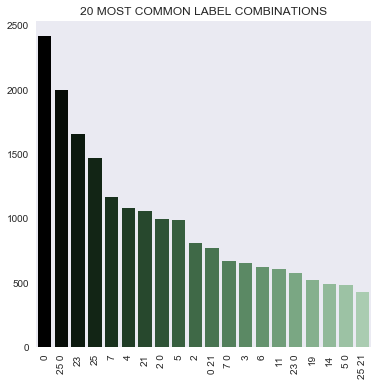

In [2]:
df = pd.read_csv(train_csv_path)

TRAINING_SAMPLES = df.shape[0]

print("we have " + str(TRAINING_SAMPLES) + " different samples")
print("And there are "+  str(len(df.Target.unique())) + " different combinations of labels in our dataset")

import seaborn as sns
sns.set(style="dark")

n = 20

values = df['Target'].value_counts()[:n].keys().tolist()
counts = df['Target'].value_counts()[:n].tolist()

plt.figure(figsize=(6,6))
pal = sns.cubehelix_palette(n, start=2, rot=0, dark=0, light=.75, reverse=True)
g = sns.barplot(y=counts, x=values, palette=pal)
g.set_title(str(n)+" MOST COMMON LABEL COMBINATIONS")
g.set_xticklabels(g.get_xticklabels(),rotation=90);


In [3]:
from PIL import Image

def load_image(basepath, image_id):
    images = np.zeros(shape=(256,256,4))
    r = Image.open(basepath+image_id+"_red.png").resize((256,256))
    g = Image.open(basepath+image_id+"_green.png").resize((256,256))
    b = Image.open(basepath+image_id+"_blue.png").resize((256,256))
    y = Image.open(basepath+image_id+"_yellow.png").resize((256,256))

    images[:,:,0] = np.asarray(r)
    images[:,:,1] = np.asarray(g)
    images[:,:,2] = np.asarray(b)
    images[:,:,3] = np.asarray(y)
    
    return images

In [4]:
targets = df['Target'].value_counts().keys()
counts = df['Target'].value_counts().values

how_many = counts/TRAINING_SAMPLES*DATASET_SIZE

# at least one example of each possible combination of labels..
how_many = how_many.astype('int')+1

In [5]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
warnings.filterwarnings("ignore")
from skimage import io, transform
from sklearn.preprocessing import MultiLabelBinarizer
classes = np.arange(0,28)
mlb = MultiLabelBinarizer(classes)
mlb.fit(classes)

class HumanProteinDataset(Dataset):

    def __init__(self, csv_file,transform=None, test=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            test (Boolean): the csv no contains labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.test = test
        self.complete_df = pd.read_csv(csv_file)
        
        if not test:
            self.path = train_path
            self.loadData()
        else:
            self.path = test_path
            self.df = self.complete_df
            
        self.transform = transform
        
    def CreateDummyVariables(self):
        self.complete_df['Targets'] = self.complete_df['Target'].map(lambda x: list(map(int, x.strip().split())))
            
    def loadData(self):
        self.CreateDummyVariables()
        self.df = pd.DataFrame(columns=['Id','Target'])
        for i, target in enumerate(targets):
            fdf = self.complete_df[self.complete_df['Target'] == target]
            sample = fdf.sample(n=how_many[i], replace=False)
            self.df = self.df.append(sample)
        self.df = self.df.sample(frac=1).reset_index(drop=True)
            
    def __getitem__(self, idx):
        
        image = load_image(self.path, self.df['Id'].iloc[idx])
        
        sample = {'image': image}

        if not self.test:
            target = np.array(self.complete_df['Targets'].iloc[idx])
            target = mlb.transform([target])
            sample['target'] = target
        
        else:
            sample['Id'] = self.df['Id'].iloc[idx]

        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def __len__(self):
        return self.df.shape[0]
    
    def shape(self):
        return self.df.shape
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        
        image = sample['image']/255.0
        
        totensor = transforms.ToTensor()
        
        ret = {'image': totensor(image)}
        
        if "target" in sample.keys():
            target = sample['target'][0]
            ret['target'] = target
        else:
            ret['Id'] = sample['Id']
                  
        return ret

In [6]:
dataset = HumanProteinDataset(train_csv_path, transform=ToTensor())

In [7]:
def Show(sample):
    f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(25,25), sharey=True)

    title = ''
    
    labels =sample['target']
                
    for i, label in enumerate(LABELS):
        if labels[i] == 1:
            if title == '':
                title += label
            else:
                title += " & " + label
            
    ax1.imshow(sample['image'][0,:,:],cmap="hot")
    ax1.set_title('Red')
    ax2.imshow(sample['image'][1,:,:],cmap="copper")
    ax2.set_title('Green')
    ax3.imshow(sample['image'][2,:,:],cmap="bone")
    ax3.set_title('Blue')
    ax4.imshow(sample['image'][3,:,:],cmap="afmhot")
    ax4.set_title('Yellow')
    f.suptitle(title, fontsize=20, y=0.62)

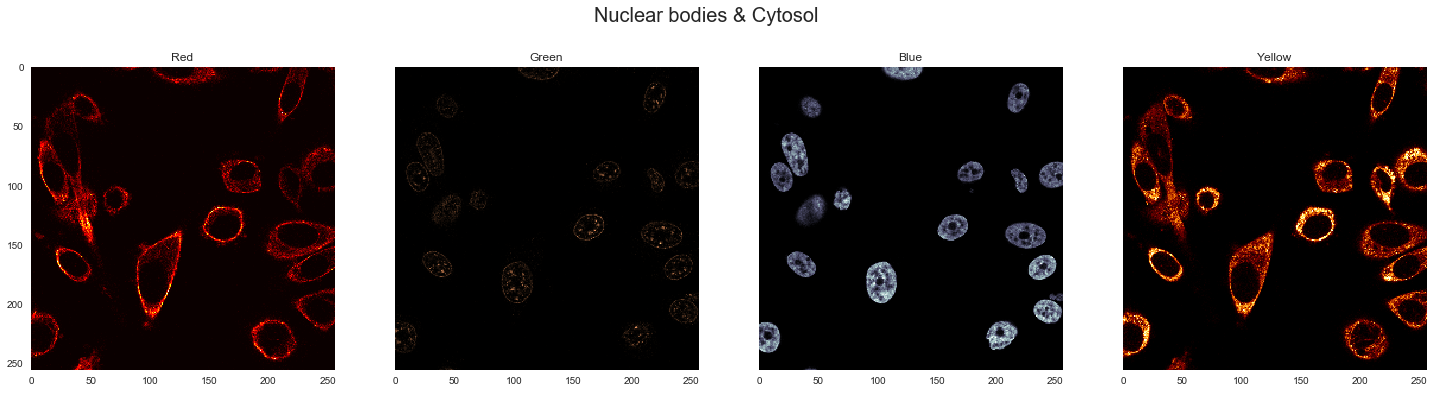

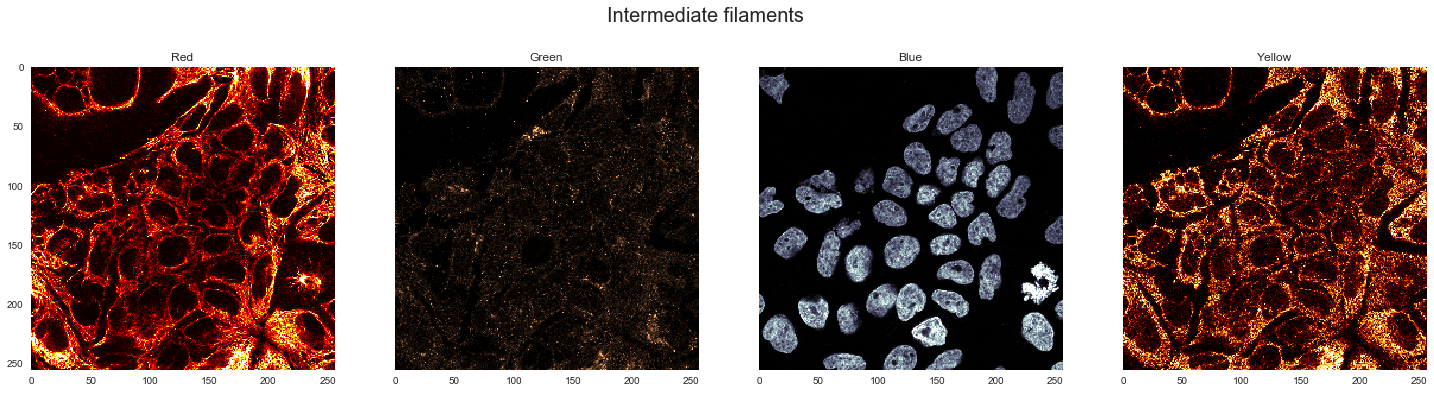

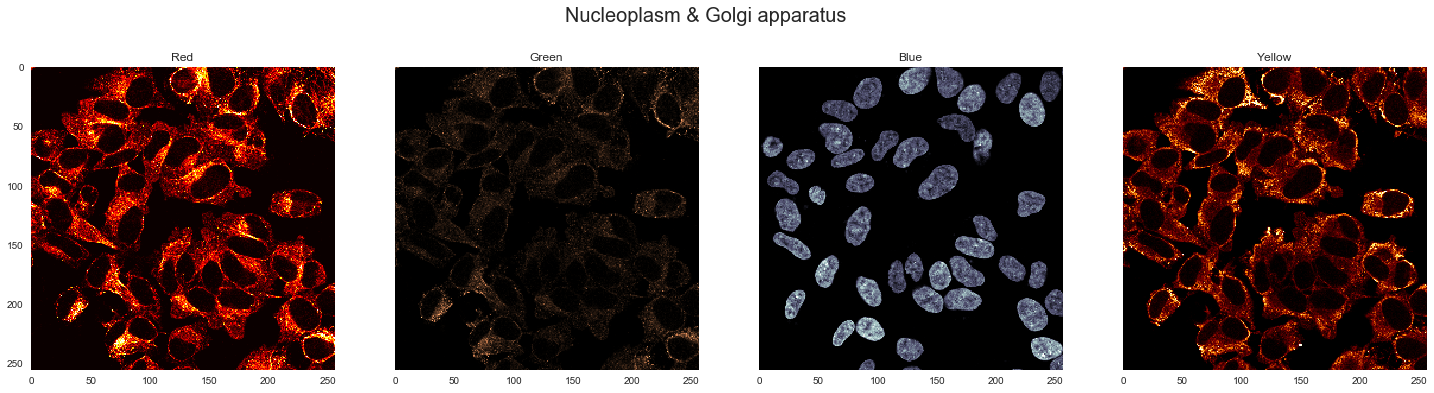

In [8]:
import random

idxs = random.sample(range(1, dataset.df.shape[0]), 3)

for idx in idxs:
    Show(dataset[idx])

In [9]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
import math

def prepare_loaders():
    dataset.loadData()
    num_train = len(dataset)
    indices = list(range(num_train))
    val_size = int(0.45 * num_train) 

    # Random, non-contiguous split
    validation_idx = np.random.choice(indices, size=val_size, replace=False)
    train_idx = list(set(indices) - set(validation_idx))

    train_sampler = SubsetRandomSampler(train_idx)
    validation_sampler = SubsetRandomSampler(validation_idx)

    dataset_sizes = {}

    dataset_sizes['train'] = len(train_idx)
    dataset_sizes['val'] = len(validation_idx)
    
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE,num_workers=0, sampler=train_sampler)
    validation_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=0,sampler=validation_sampler)

    dataloaders = {}

    dataloaders['train'] = train_loader
    dataloaders['val'] = validation_loader
    
    return (dataloaders, dataset_sizes)


In [10]:
dataloaders, dataset_sizes = prepare_loaders()

dataset.df.head()

,Id,Target,Targets
0,1984433a-bbc6-11e8-b2bc-ac1f6b6435d0,1 0 21,"[1, 0, 21]"
1,79811962-bba2-11e8-b2b9-ac1f6b6435d0,5,[5]
2,9054c970-bbb3-11e8-b2ba-ac1f6b6435d0,23 0,"[23, 0]"
3,d02f4ecc-bba8-11e8-b2ba-ac1f6b6435d0,23 17 0,"[23, 17, 0]"
4,9095faec-bbbf-11e8-b2bb-ac1f6b6435d0,7 2,"[7, 2]"


In [11]:
# Wout = 1 + (Win - Kernel_size + 2Padding)/Stride

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(      #input: 4xWxH
            nn.Conv2d(4,8,5,1,2),        # input_channels, output_channels, kernel_size, stride, padding   
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), #output: 8xW/2xH/2
        )
        self.conv2 = nn.Sequential(      #input: 4xWxH
            nn.Conv2d(8,16,5,1,2),        # input_channels, output_channels, kernel_size, stride, padding   
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), #output: 16xW/4xH/4
        )
        self.drop_out = nn.Dropout()
        self.out1 = nn.Linear( int(16 * W/4 * H/4), 900)   # fully connected layer, output 28 classes
        self.out2 = nn.Linear( 900, 28)   # fully connected layer, output 28 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.drop_out(x)
        output = self.out1(x)
        output = self.out2(output)
        return output, x    # return x for visualization

def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

In [12]:
# create a new subdataset for training
dataloaders, dataset_sizes = prepare_loaders()

In [13]:
losses = {}
accuracys = {}

losses['train'] = []
losses['val'] = []
accuracys['train'] = []
accuracys['val'] = []

In [14]:
def Train(model, epochs=10, criterion=nn.BCEWithLogitsLoss(reduction='sum'), optimizer= None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    if optimizer == None:
        optimizer = optim.Adam(model.parameters(), lr=0.04, betas=(0.9, 0.99))
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("training with device: " + str(device))
    
    model.to(device)
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0    
            running_corrects = 0.0
    
            for i, data in enumerate(dataloaders[phase], 0):            
                # get the inputs
                inputs, labels = data['image'], data['target']

                inputs, labels = inputs.to(device,dtype=torch.float), labels.to(device,dtype=torch.float)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)[0]
                    preds = outputs > 0
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                 # statistics
                running_loss += loss.item() * inputs.size(0)
                labels = labels.data.byte()
                running_corrects += torch.sum((labels == preds).all(1))
                                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            losses[phase].append(epoch_loss)
            accuracys[phase].append(epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def run_model(model,batch):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = batch
    inputs = inputs.to(device,dtype=torch.float)
    out = model(inputs)
    out = out[0].cpu()
    return out

In [15]:
# model creation and initialization
cnn = CNN()
cnn.apply(init_weights)

CNN(
  (conv1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5)
  (out1): Linear(in_features=65536, out_features=900, bias=True)
  (out2): Linear(in_features=900, out_features=28, bias=True)
)

In [16]:
# training
torch.cuda.empty_cache()
cnn = Train(cnn, epochs=10,  criterion=nn.BCEWithLogitsLoss(reduction='sum'), optimizer = optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.99)))

training with device: cuda:0
Epoch 1/10
----------
train Loss: 133.9021 Acc: 0.0165
val Loss: 104.2949 Acc: 0.0031
Epoch 2/10
----------
train Loss: 98.6496 Acc: 0.0158
val Loss: 105.0696 Acc: 0.0023
Epoch 3/10
----------
train Loss: 85.6270 Acc: 0.0810
val Loss: 109.1598 Acc: 0.0209
Epoch 4/10
----------
train Loss: 52.5107 Acc: 0.3316
val Loss: 145.4095 Acc: 0.0271
Epoch 5/10
----------
train Loss: 27.4951 Acc: 0.6297
val Loss: 207.5645 Acc: 0.0426
Epoch 6/10
----------
train Loss: 15.1032 Acc: 0.7861
val Loss: 259.7187 Acc: 0.0380
Epoch 7/10
----------
train Loss: 11.4879 Acc: 0.8557
val Loss: 312.5111 Acc: 0.0457
Epoch 8/10
----------
train Loss: 7.8664 Acc: 0.8937
val Loss: 372.0170 Acc: 0.0395
Epoch 9/10
----------
train Loss: 6.3485 Acc: 0.9165
val Loss: 374.4010 Acc: 0.0480
Epoch 10/10
----------
train Loss: 4.4440 Acc: 0.9367
val Loss: 407.1336 Acc: 0.0341
Training complete in 10m 40s
Best val Acc: 0.048025


In [17]:
# training
torch.cuda.empty_cache()
cnn = Train(cnn, epochs=10,  criterion=nn.BCEWithLogitsLoss(reduction='sum'), optimizer = optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.99)))
dataloaders, dataset_sizes = prepare_loaders()
torch.cuda.empty_cache()
cnn = Train(cnn, epochs=10,  criterion=nn.BCEWithLogitsLoss(reduction='sum'), optimizer = optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.99)))

training with device: cuda:0
Epoch 1/10
----------
train Loss: 6.7071 Acc: 0.9063
val Loss: 381.0817 Acc: 0.0449
Epoch 2/10
----------
train Loss: 5.0439 Acc: 0.9361
val Loss: 469.7720 Acc: 0.0395
Epoch 3/10
----------
train Loss: 2.9509 Acc: 0.9595
val Loss: 535.8273 Acc: 0.0465
Epoch 4/10
----------
train Loss: 3.2486 Acc: 0.9595
val Loss: 500.6525 Acc: 0.0387
Epoch 5/10
----------
train Loss: 4.2629 Acc: 0.9386
val Loss: 495.0945 Acc: 0.0426
Epoch 6/10
----------
train Loss: 4.4058 Acc: 0.9608
val Loss: 485.8414 Acc: 0.0380
Epoch 7/10
----------
train Loss: 2.6308 Acc: 0.9766
val Loss: 440.7764 Acc: 0.0457
Epoch 8/10
----------
train Loss: 1.3107 Acc: 0.9848
val Loss: 556.0191 Acc: 0.0465
Epoch 9/10
----------
train Loss: 1.7078 Acc: 0.9810
val Loss: 554.8563 Acc: 0.0411
Epoch 10/10
----------
train Loss: 1.6062 Acc: 0.9772
val Loss: 528.6110 Acc: 0.0403
Training complete in 10m 48s
Best val Acc: 0.046476
training with device: cuda:0
Epoch 1/10
----------
train Loss: 137.4751 Acc: 0

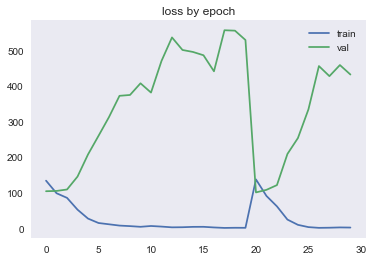

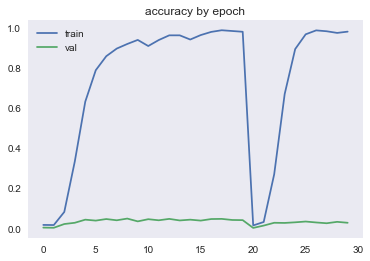

In [18]:
plt.plot(np.arange(len(losses['train'])), losses['train'],label="train")
plt.plot(np.arange(len(losses['val'])), losses['val'], label="val")
plt.legend()
plt.title("loss by epoch")
plt.show()

plt.plot(np.arange(len(accuracys['train'])), accuracys['train'], label="train")
plt.plot(np.arange(len(accuracys['val'])), accuracys['val'], label="val")
plt.title("accuracy by epoch")
plt.legend()
plt.show()

In [19]:
def save(model, full = True, name="model"):
    if not full:
        torch.save(model.state_dict(), name+'_params.pkl')   # save only the parameters
    else:
        torch.save(model, name+'.pkl')  # save entire net

        
def restore_net(name="model"):
    model = torch.load(name+'.pkl')
    return model
    

In [20]:
save(cnn, name="cnn")
!ls

'ls'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [21]:
cnn = restore_net(name="cnn")

In [22]:
submit = pd.read_csv('C:/Users/ehgml/data/sample_submission.csv')

dataset_test = HumanProteinDataset(csv_file='C:/Users/ehgml/data/sample_submission.csv', transform=transforms.Compose([
    ToTensor()
]), test=True)

dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=0)

In [23]:
ids = []
predictions = []

# cnn = cnn.cuda()

for sample_batched in dataloader_test:
        out = run_model(cnn,sample_batched['image'])
        
        preds = []
        out = out.detach().numpy()
        for sample in out:
            p = ""
            for i,label in enumerate(sample):
                if label > 0:
                    p += " " + str(i)
                    print(p)
            if p == "":
                p = "0"
            else:
                p = p[1:]
            preds.append(p)

        ids += list(sample_batched['Id'])
        predictions += preds


 25
 25
 0
 0 25
 5
 0
 0
 0 21
 5
 5 21
 0
 7
 0
 0
 21
 0
 0 25
 0
 0 25
 0
 25
 25
 0
 0
 0
 0 2
 0
 0
 0
 0
 0
 0
 0
 0 7
 0
 0
 7
 7 21
 0
 0
 0
 0 2
 25
 0
 0
 0
 0 7
 0
 0
 0 25
 0
 0 7
 0
 0 25
 0
 0
 0 2
 0 2 21
 25
 0
 0 25
 0
 0
 21
 0
 25
 0
 0
 0
 0
 0 25
 0
 0 25
 25
 2
 2 25
 25
 25
 11
 11 18
 25
 0
 0
 0
 0
 25
 0
 0 25
 0
 25
 0
 0 25
 0
 0
 0
 0 2
 0
 0
 0
 0
 0
 21
 0
 0
 0 25
 0
 0 25
 0
 0 23
 0
 0
 0
 2
 2 25
 0
 0 25
 0
 0 25
 0
 0 25
 0
 0
 0 23
 25
 0
 0 25
 0
 0
 25
 0
 0 25
 0
 0
 0 25
 0
 0
 0 2
 0
 0 25
 25
 0
 0
 0
 1
 1 23
 1 23 25
 25
 0
 0
 0
 0
 0
 0 7
 0
 0
 0
 0
 0 25
 0
 0
 0
 0
 25
 0
 7
 25
 0
 25
 0
 0 21
 0
 25
 25
 25
 25
 0
 0
 2
 0
 0
 0
 0
 0
 21
 21 25
 0
 0
 0 25
 25
 6
 0
 0
 0 23
 0
 0 2
 0 2 7
 0
 7
 0
 0
 21
 21 25
 0
 0
 0
 0
 0
 0 5
 0
 0 25
 23
 0
 0
 7
 25
 0
 0
 0 25
 0
 0 21
 5
 0
 0
 0
 0 25
 0
 0 21
 25
 0
 14
 25
 25
 0
 0
 0
 0 3
 0 3 25
 25
 0
 23
 23 25
 25
 0
 0 5
 0
 0
 0
 0
 0
 25
 0
 0 7
 0
 0
 0 21
 0
 0
 0
 0
 0 25
 

 23
 23 25
 0
 0
 0
 0 25
 0
 0 25
 0
 0 25
 0
 0
 25
 0
 25
 4
 0
 0
 25
 0
 0
 0
 0 25
 0
 0
 0
 0
 21
 21 25
 0
 0
 0
 0
 25
 0
 0
 0
 0 21
 0
 0
 0 25
 0
 0 25
 0
 25
 0
 0 25
 0
 25
 0
 0 25
 0
 0 25
 0
 25
 0
 0 25
 0
 6
 0
 0 25
 0
 21
 0
 0 25
 0
 25
 25
 25
 0
 25
 25
 0
 0 25
 25
 25
 0
 0 21
 21
 21 25
 0
 0 23
 0
 0
 0
 0 25
 7
 25
 3
 0
 0 3
 0
 0 7
 0 7 25
 25
 5
 5 25
 25
 14
 0
 0 25
 14
 0
 0
 25
 0
 0
 0 2
 0
 0 25
 25
 0
 7
 25
 7
 0
 0
 21
 0
 0
 0 3
 21
 21
 21 25
 0
 25
 25
 0
 0
 0 25
 0
 2
 2 3
 0
 25
 23
 0
 0
 0 25
 25
 25
 0
 25
 25
 25
 0
 25
 0
 0 25
 0
 25
 0
 25
 0
 25
 0
 11
 5
 0
 0
 25
 0
 0
 0
 25
 0
 0 7
 25
 0
 0 7
 0
 0
 0 25
 0
 0
 0
 0 25
 0
 0
 0 25
 0
 0 25
 0
 11
 11 23
 0
 23
 0
 0 25
 0
 0 25
 0
 0 25
 21
 21 25
 0
 0
 25
 25
 0
 0 25
 23
 0
 21
 0
 0
 0
 0 25
 0
 0
 0 25
 25
 0
 0
 0 21
 25
 7
 0
 0
 0
 0
 23
 0
 0
 0
 0
 0 25
 25
 5
 25
 25
 0
 0
 0
 0 2
 0 2 25
 0
 25
 0
 0 25
 0
 3
 11
 0
 0 25
 21
 25
 0
 0 25
 25
 0
 0 25
 25
 0
 0 25


 0
 0 2
 0
 0
 0
 0
 25
 0
 0
 25
 0
 0
 0
 0 25
 0
 0
 0
 0
 21
 14
 0
 0
 0
 0
 25
 0
 0
 25
 0
 25
 11
 0
 0
 0
 0
 0 25
 25
 11
 25
 0
 0 25
 0
 0
 0
 25
 0
 0
 0 25
 25
 21
 0
 23
 0
 0 25
 5
 0
 0 25
 0
 0 25
 0
 0 5
 0
 21
 21 25
 21
 21 23
 0
 0
 0
 0 2
 0
 0 2
 0
 0
 0
 0
 0
 0
 0 25
 4
 21
 21 23
 21
 21 25
 0
 0
 0 25
 0
 25
 21
 21 25
 0
 0 25
 0
 21
 0
 0
 0
 0
 0
 0
 25
 0
 0
 0
 0
 0
 0
 25
 0
 0
 0 3
 25
 0
 0
 0 25
 14
 14 23
 14 23 25
 0
 0
 0
 0 25
 0
 0 25
 23
 0
 21
 21 25
 0
 0
 0
 0 25
 0
 0
 25
 0
 0
 25
 0
 0 25
 0
 0 25
 0
 23
 5
 5 25
 23
 0
 0 25
 0
 0
 5
 5 21
 5 21 25
 25
 23
 0
 0
 0 25
 0
 0 21
 0
 0 2
 0 2 25
 0
 25
 0
 25
 0
 0 5
 0 5 25
 0
 0
 0
 0
 0
 0
 25
 5
 25
 0
 0 25
 0
 0
 0
 0 2
 0 2 25
 0
 25
 0
 0
 0
 0
 0 25
 0
 25
 0
 0 25
 0
 0
 0 2
 0
 3
 25
 0
 0
 0 25
 0
 0
 0
 0
 7
 0
 25
 0
 0
 25
 7
 25
 0
 0
 0 11
 7
 21
 21 25
 0
 0
 0
 0 7
 0
 0 25
 0
 25
 0
 0 7
 0
 0 7
 25
 0
 0 25
 0
 21
 0
 0 25
 7
 7 25
 21
 23
 0
 0 23
 0
 0
 0 25
 0
 0
 2

 21
 25
 0
 0 25
 0
 0
 0 7
 0
 0 25
 0
 0
 11
 11 23
 0
 23
 25
 0
 0 25
 0
 0
 25
 0
 0 21
 0 21 25
 0
 0 25
 11
 0
 0
 25
 0
 0
 0
 0
 25
 0
 0 25
 23
 0
 7
 0
 0
 0 7
 0
 0
 0
 21
 5
 25
 0
 0
 25
 0
 0 4
 0
 0
 0
 0 7
 0
 25
 25
 0
 0 25
 21
 0
 0
 0
 25
 4
 4 25
 0
 25
 0
 0
 0
 0 23
 0
 0
 25
 0
 0
 25
 25
 0
 5
 5 23
 0
 0
 0 25
 23
 0
 0
 0
 0
 0
 0 25
 0
 0
 0 25
 0
 2
 2 21
 2 21 25
 0
 0
 0
 0
 0
 0
 7
 0
 0
 0 5
 25
 0
 0
 0 5
 0
 25
 0
 0
 0
 0
 0
 25
 25
 25
 0
 0
 25
 0
 0
 0
 0
 25
 25
 25
 0
 0
 0
 0 25
 0
 21
 0
 0
 0
 0
 0
 0 25
 0
 25
 0
 0
 0
 0
 25
 0
 0
 25
 0
 21
 0
 0
 0
 11
 25
 0
 25
 0
 7
 7 25
 0
 0 25
 0
 0 7
 0
 25
 0
 0
 0
 6
 0
 25
 25
 0
 25
 0
 25
 0
 25
 0
 0 23
 14
 14 21
 0
 0
 0 25
 25
 0
 0
 0
 25
 14
 14 23
 25
 7
 7 21
 0
 0
 0
 0
 0 25
 7
 0
 0
 25
 0
 25
 0
 0
 0
 7
 0
 25
 25
 21
 0
 0
 0 25
 0
 0 25
 25
 0
 0
 25
 0
 0
 0 7
 0
 0 25
 0
 0
 25
 0
 0
 0
 0 25
 0
 0
 0
 7
 7 21
 7
 25
 0
 0
 25
 0
 0 21
 25
 21
 21 25
 25
 21
 25
 25
 0
 0 25

In [24]:
print(predictions)


['25', '25', '0', '0 25', '5', '0', '0', '0', '0 21', '0', '5 21', '0', '7', '0', '0', '0', '21', '0 25', '0 25', '0', '0', '0', '0', '0', '0', '25', '0', '25', '0', '0', '0', '0', '0', '0', '0 2', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0 7', '0', '0', '7 21', '0', '0', '0 2', '0', '0', '25', '0', '0', '0', '0', '0', '0', '0', '0 7', '0', '0', '0', '0 25', '0', '0', '0', '0 7', '0', '0 25', '0', '0', '0 2 21', '0', '25', '0 25', '0', '0', '0', '21', '0', '25', '0', '0', '0', '0', '0', '0 25', '0 25', '25', '2 25', '25', '0', '25', '11 18', '0', '25', '0', '0', '0', '0', '0', '0', '25', '0 25', '0', '0', '0', '25', '0 25', '0', '0', '0 2', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '21', '0', '0', '0 25', '0', '0 25', '0 23', '0', '0', '0', '0', '0', '2 25', '0 25', '0 25', '0', '0', '0', '0', '0 25', '0', '0 23', '0', '0', '0', '0', '25', '0 25', '0', '0', '0', '25', '0 25', '0', '0', '0', '0', '0'

In [25]:
df = pd.DataFrame({'Id':ids,'Predicted':predictions})
df.to_csv('protein_classification.csv', header=True, index=False)

print(df)

                                         Id Predicted
0      00008af0-bad0-11e8-b2b8-ac1f6b6435d0        25
1      0000a892-bacf-11e8-b2b8-ac1f6b6435d0        25
2      0006faa6-bac7-11e8-b2b7-ac1f6b6435d0         0
3      0008baca-bad7-11e8-b2b9-ac1f6b6435d0      0 25
4      000cce7e-bad4-11e8-b2b8-ac1f6b6435d0         5
5      00109f6a-bac8-11e8-b2b7-ac1f6b6435d0         0
6      001765de-bacd-11e8-b2b8-ac1f6b6435d0         0
7      0018641a-bac9-11e8-b2b8-ac1f6b6435d0         0
8      00200f22-bad7-11e8-b2b9-ac1f6b6435d0      0 21
9      0026f154-bac6-11e8-b2b7-ac1f6b6435d0         0
10     002729d2-bace-11e8-b2b8-ac1f6b6435d0      5 21
11     002c1a7c-bad4-11e8-b2b8-ac1f6b6435d0         0
12     003170fa-bacd-11e8-b2b8-ac1f6b6435d0         7
13     0031820a-baca-11e8-b2b8-ac1f6b6435d0         0
14     00407c16-bad3-11e8-b2b8-ac1f6b6435d0         0
15     005ce2ea-bacc-11e8-b2b8-ac1f6b6435d0         0
16     00631ec8-bad9-11e8-b2b9-ac1f6b6435d0        21
17     00673f64-bad2-11e8-b2

In [26]:
# import the modules we'll need
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "protein_classification.csv"):  
    csv = df.to_csv( sep=',', encoding='utf-8', index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)


# create a link to download the dataframe
create_download_link(df)